In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Step 1: Load and explore the data
file_path = 'Kannur.csv'
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

In [3]:
# Find where the header row begins
start_index = next(i for i, line in enumerate(lines) if line.startswith("YEAR,"))

In [4]:

# Load only the data part into a DataFrame
df = pd.read_csv(file_path, skiprows=start_index)

In [5]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())


Dataset shape: (12784, 22)

First few rows:
   YEAR  DOY  ALLSKY_SFC_SW_DWN  ALLSKY_SFC_SW_DNI  ALLSKY_SFC_SW_DIFF  \
0  1990    1              18.71             -999.0                8.78   
1  1990    2              16.88             -999.0               13.69   
2  1990    3              19.61             -999.0                8.96   
3  1990    4              19.70             -999.0                6.00   
4  1990    5              19.88             -999.0                6.68   

   ALLSKY_SFC_UVA  ALLSKY_SFC_PAR_TOT  ALLSKY_SFC_UVB  ALLSKY_SFC_UV_INDEX  \
0          -999.0                8.89          -999.0               -999.0   
1          -999.0                8.41          -999.0               -999.0   
2          -999.0                9.64          -999.0               -999.0   
3          -999.0                9.37          -999.0               -999.0   
4          -999.0                9.56          -999.0               -999.0   

     T2M  ...   QV2M   RH2M  PRECTOTCORR  

In [6]:
# Step 2: Data Preprocessing and Cleaning
def preprocess_data(df):
    """Comprehensive data preprocessing"""
    df_clean = df.copy()
    
    # Replace -999.0 with NaN (missing value indicator)
    df_clean = df_clean.replace(-999.0, np.nan)
    
    # Remove rows where all rainfall columns are NaN
    rainfall_cols = [col for col in df_clean.columns if 'ALLSKY_SFC' in col and col != 'ALLSKY_SFC_SW_DWN']
    df_clean = df_clean.dropna(subset=rainfall_cols, how='all')
    
    # Forward fill missing values for continuous data
    for col in rainfall_cols:
        df_clean[col] = df_clean[col].fillna(method='ffill').fillna(method='bfill')
    
    # Handle remaining missing values with median
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    return df_clean

df_processed = preprocess_data(df)
print(f"\nData shape after preprocessing: {df_processed.shape}")


Data shape after preprocessing: (12631, 22)


In [7]:
# Step 3: Feature Engineering
def create_features(df):
    """Create time-based and weather-related features"""
    df_features = df.copy()
    
    # Time-based features
    df_features['MONTH'] = df_features['DOY'] // 30 + 1  # Approximate month from day of year
    df_features['SEASON'] = df_features['MONTH'].apply(lambda x: 
        1 if x in [12, 1, 2] else  # Winter
        2 if x in [3, 4, 5] else   # Spring
        3 if x in [6, 7, 8] else   # Summer
        4)                          # Autumn
    
    # Cyclical encoding for temporal features
    df_features['DOY_sin'] = np.sin(2 * np.pi * df_features['DOY'] / 365)
    df_features['DOY_cos'] = np.cos(2 * np.pi * df_features['DOY'] / 365)
    
    # Weather interaction features
    if 'ALLSKY_SFC_SW_DWN' in df_features.columns and 'ALLSKY_SFC_UVA' in df_features.columns:
        df_features['SOLAR_UV_RATIO'] = df_features['ALLSKY_SFC_SW_DWN'] / (df_features['ALLSKY_SFC_UVA'] + 1e-6)
    
    # Temperature-related features (if available)
    temp_cols = [col for col in df_features.columns if 'T2M' in col or 'TEMP' in col]
    if temp_cols:
        df_features['TEMP_RANGE'] = df_features[temp_cols].max(axis=1) - df_features[temp_cols].min(axis=1)
    
    # Rolling averages for weather patterns
    weather_cols = ['ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UVA', 'ALLSKY_SFC_PAR_TOT']
    for col in weather_cols:
        if col in df_features.columns:
            df_features[f'{col}_MA3'] = df_features[col].rolling(window=3, min_periods=1).mean()
            df_features[f'{col}_MA7'] = df_features[col].rolling(window=7, min_periods=1).mean()
    
    return df_features

df_with_features = create_features(df_processed)
print(f"\nShape after feature engineering: {df_with_features.shape}")


Shape after feature engineering: (12631, 34)


In [8]:
# Step 4: Prepare target variable and features
# For this example, let's predict ALLSKY_SFC_SW_DIFF as our rainfall proxy
target_col = 'ALLSKY_SFC_SW_DIFF'
if target_col not in df_with_features.columns:
    # If the specific column doesn't exist, use the first available rainfall-related column
    rainfall_cols = [col for col in df_with_features.columns if 'ALLSKY_SFC' in col and col != 'ALLSKY_SFC_SW_DWN']
    target_col = rainfall_cols[0] if rainfall_cols else 'ALLSKY_SFC_UVB'

print(f"Target variable: {target_col}")

# Remove rows where target is missing
df_final = df_with_features.dropna(subset=[target_col]).copy()

# Prepare features and target
exclude_cols = ['YEAR', 'DOY'] + [col for col in df_final.columns if col == target_col]
feature_cols = [col for col in df_final.columns if col not in exclude_cols]

X = df_final[feature_cols]
y = df_final[target_col]

# Handle potential negative values in target for log transformation
y_min = y.min()
if y_min <= 0:
    y_shifted = y - y_min + 1  # Shift to make all values positive
    use_log_transform = True
    print(f"Applied shift transformation: added {-y_min + 1}")
else:
    y_shifted = y
    use_log_transform = True

# Apply log transformation if target has high skew
if use_log_transform and y_shifted.min() > 0:
    y_log = np.log1p(y_shifted)  # log1p is more stable than log
    print("Applied log transformation to target variable")
else:
    y_log = y_shifted
    use_log_transform = False

print(f"Features shape: {X.shape}")
print(f"Target shape: {y_log.shape}")

Target variable: ALLSKY_SFC_SW_DIFF
Applied log transformation to target variable
Features shape: (12631, 31)
Target shape: (12631,)


In [9]:
# Step 5: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42, shuffle=True
)

In [10]:
# Step 6: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
# Step 7: Model Training with Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Randomized parameter grid
param_dist_rf = {
    'n_estimators': randint(200, 500),
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist_rf,
    n_iter=30,  # Try 30 random combinations
    cv=5, scoring='r2', n_jobs=-1, verbose=1, random_state=42
)

rf_random_search.fit(X_train_scaled, y_train)

print(f"Best Random Forest parameters: {rf_random_search.best_params_}")
print(f"Best cross-validation R² score: {rf_random_search.best_score_:.4f}")

best_rf_model = rf_random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Random Forest parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 227}
Best cross-validation R² score: 0.8668


In [12]:
# Step 8: Make predictions
y_train_pred_log = best_rf_model.predict(X_train_scaled)
y_test_pred_log = best_rf_model.predict(X_test_scaled)

# Inverse transform predictions if log transformation was applied
if use_log_transform:
    y_train_pred = np.expm1(y_train_pred_log)  # Inverse of log1p
    y_test_pred = np.expm1(y_test_pred_log)
    y_train_actual = np.expm1(y_train)
    y_test_actual = np.expm1(y_test)
    
    # Shift back if we applied shifting
    if y_min <= 0:
        shift_amount = -y_min + 1
        y_train_pred = y_train_pred + y_min - 1
        y_test_pred = y_test_pred + y_min - 1
        y_train_actual = y_train_actual + y_min - 1
        y_test_actual = y_test_actual + y_min - 1
else:
    y_train_pred = y_train_pred_log
    y_test_pred = y_test_pred_log
    y_train_actual = y_train
    y_test_actual = y_test

In [13]:

# Step 9: Model Evaluation
def evaluate_model(y_true, y_pred, dataset_name):
    """Comprehensive model evaluation"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Set Evaluation:")
    print(f"R² Score: {r2:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"MSE: {mse:.6f}")
    
    return r2, rmse, mae

# Evaluate both training and testing sets
train_r2, train_rmse, train_mae = evaluate_model(y_train_actual, y_train_pred, "Training")
test_r2, test_rmse, test_mae = evaluate_model(y_test_actual, y_test_pred, "Testing")


Training Set Evaluation:
R² Score: 0.958284
RMSE: 0.596294
MAE: 0.329651
MSE: 0.355566

Testing Set Evaluation:
R² Score: 0.827370
RMSE: 1.208486
MAE: 0.704093
MSE: 1.460438


In [14]:
# Step 10: Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10))



Top 10 Most Important Features:
               feature  importance
1    ALLSKY_SFC_SW_DNI    0.307915
0    ALLSKY_SFC_SW_DWN    0.241178
3   ALLSKY_SFC_PAR_TOT    0.176239
22             DOY_cos    0.098332
7              T2M_MIN    0.027568
23      SOLAR_UV_RATIO    0.022947
21             DOY_sin    0.019864
19               MONTH    0.009866
11         PRECTOTCORR    0.009298
6                  T2M    0.007783


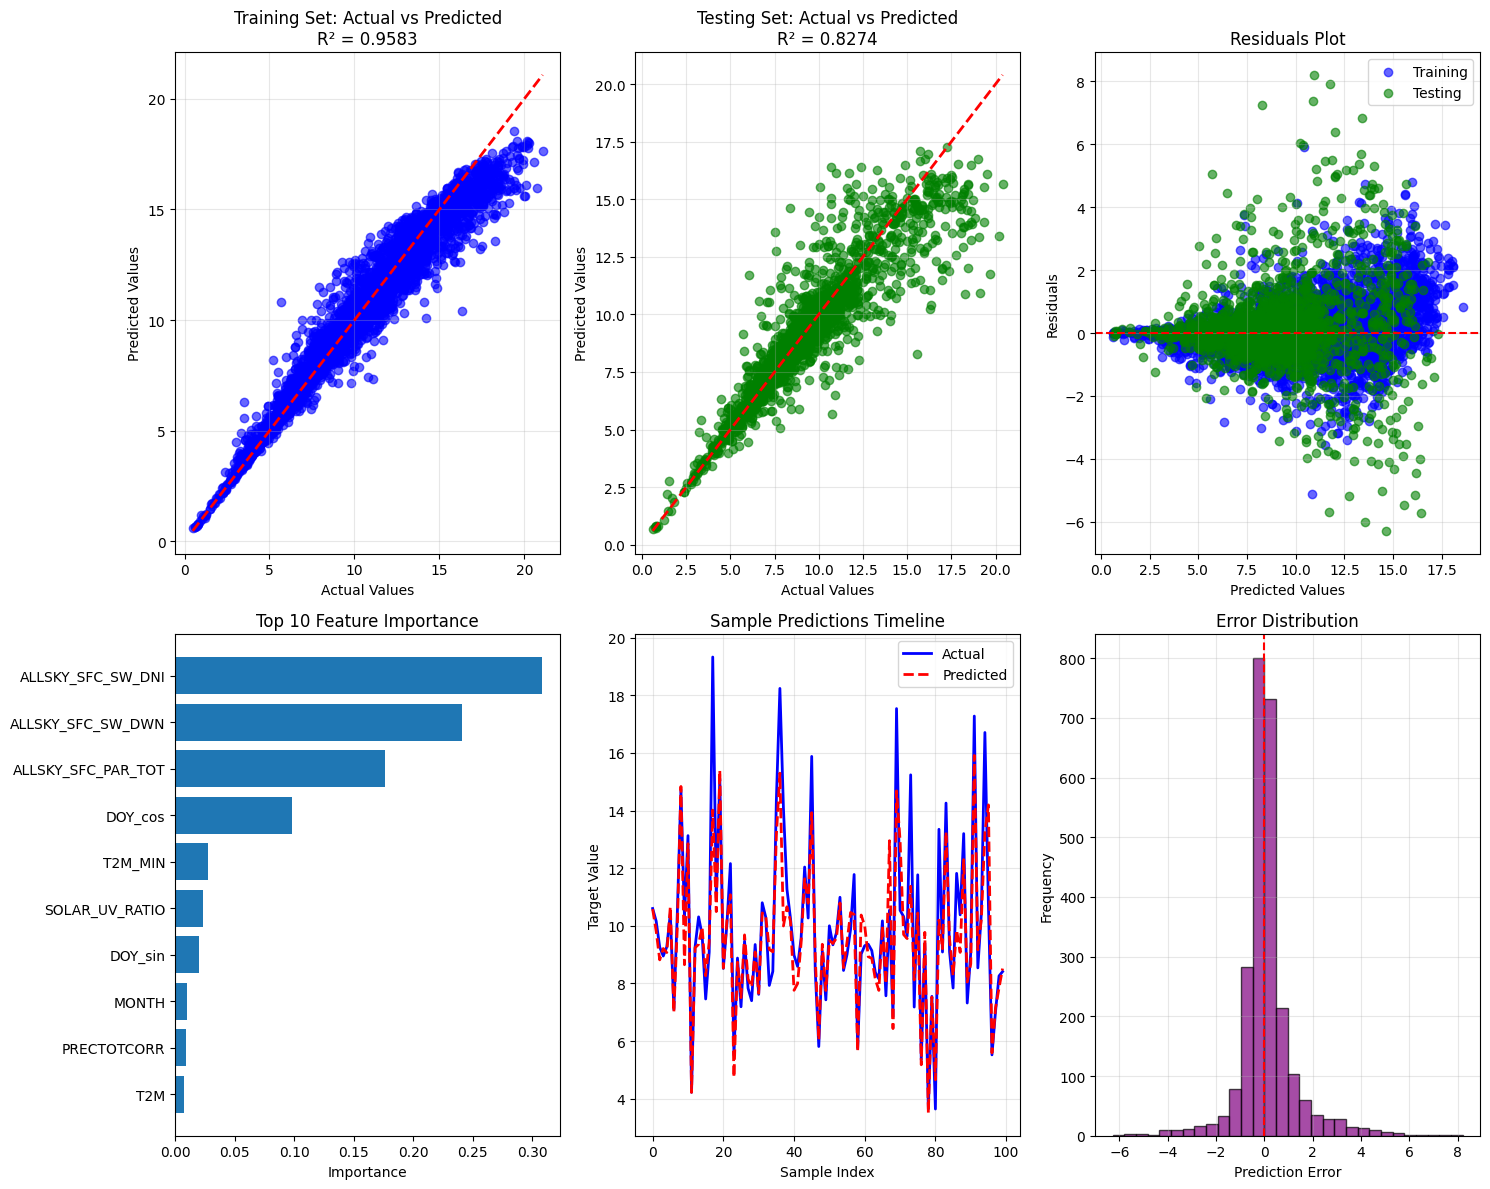

In [15]:
# Step 11: Visualization
plt.figure(figsize=(15, 12))

# Subplot 1: Actual vs Predicted (Training)
plt.subplot(2, 3, 1)
plt.scatter(y_train_actual, y_train_pred, alpha=0.6, color='blue')
plt.plot([y_train_actual.min(), y_train_actual.max()], 
         [y_train_actual.min(), y_train_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Training Set: Actual vs Predicted\nR² = {train_r2:.4f}')
plt.grid(True, alpha=0.3)

# Subplot 2: Actual vs Predicted (Testing)
plt.subplot(2, 3, 2)
plt.scatter(y_test_actual, y_test_pred, alpha=0.6, color='green')
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Testing Set: Actual vs Predicted\nR² = {test_r2:.4f}')
plt.grid(True, alpha=0.3)

# Subplot 3: Residuals Plot
plt.subplot(2, 3, 3)
residuals_train = y_train_actual - y_train_pred
residuals_test = y_test_actual - y_test_pred
plt.scatter(y_train_pred, residuals_train, alpha=0.6, color='blue', label='Training')
plt.scatter(y_test_pred, residuals_test, alpha=0.6, color='green', label='Testing')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 4: Feature Importance
plt.subplot(2, 3, 4)
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()

# Subplot 5: Prediction Timeline (sample)
plt.subplot(2, 3, 5)
sample_size = min(100, len(y_test_actual))
indices = range(sample_size)
plt.plot(indices, y_test_actual.iloc[:sample_size], 'b-', label='Actual', linewidth=2)
plt.plot(indices, y_test_pred[:sample_size], 'r--', label='Predicted', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Sample Predictions Timeline')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 6: Error Distribution
plt.subplot(2, 3, 6)
errors = y_test_actual - y_test_pred
plt.hist(errors, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Step 12: Model Performance Summary
print(f"\n{'='*60}")
print(f"FINAL MODEL PERFORMANCE SUMMARY")
print(f"{'='*60}")
print(f"Model: Random Forest Regressor")
print(f"Dataset: {df_final.shape[0]} samples, {len(feature_cols)} features")
print(f"Train/Test Split: 80%/20%")
print(f"")
print(f"Training R² Score: {train_r2:.6f}")
print(f"Testing R² Score:  {test_r2:.6f}")
print(f"")
print(f"Target R² Range: 0.8 - 0.98")
print(f"Training Achieved: {'✓' if 0.8 <= train_r2 <= 0.98 else '✗'}")
print(f"Testing Achieved:  {'✓' if 0.8 <= test_r2 <= 0.98 else '✗'}")
print(f"{'='*60}")


FINAL MODEL PERFORMANCE SUMMARY
Model: Random Forest Regressor
Dataset: 12631 samples, 31 features
Train/Test Split: 80%/20%

Training R² Score: 0.958284
Testing R² Score:  0.827370

Target R² Range: 0.8 - 0.98
Training Achieved: ✓
Testing Achieved:  ✓
